# Using Job descriptions to predict salary (rank) 

Objective: text classification and building models for predicting salary using job descriptions using python, scikit-learn and NLTK (tokenize, bag-of-words, tagging, stopwords, lemmatization) 

In [135]:
import os
import warnings
warnings.filterwarnings('ignore')
import sys  
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

import nltk
from nltk import word_tokenize
from nltk import pos_tag
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from operator import itemgetter
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [87]:
df_data = pd.read_csv("Train_rev1.csv", encoding = "ISO-8859-1")
df_sample = df_data.sample(10000)
df_sample['FullDescription'][:10]

147010    INSTORE PROMOTIONS ASSISTANT  Immediate Start ...
113854    Automotive, Motor Trade Job: Motorcycle Techni...
210556    Site or Unit :The County Care HomeAddress :***...
33286     An excellent opportunity to be part of a fast ...
72045     Our client is a major provider of precision ma...
239507    Maintenance Engineer, Maintenance Technician, ...
55862     A large school in Selby are looking for a full...
229239    With impressive growth of ****0% year on year,...
3116      The client is seeking a highly motivated and s...
173821    My client, a large international organisation,...
Name: FullDescription, dtype: object

### Exploratory Data Analysis 

Top 5 parts of speech of the job descriptions

In [88]:
corpus = df_sample['FullDescription'].str.cat().lower()
token = nltk.word_tokenize(corpus)
tag = nltk.pos_tag(token)
tags_df = DataFrame(tag)

In [45]:
tags_df[1].value_counts()[:5]

NN     325743
JJ     141203
IN     131681
NNS    103118
DT     102126
Name: 1, dtype: int64

How frequently they appear in the corpus

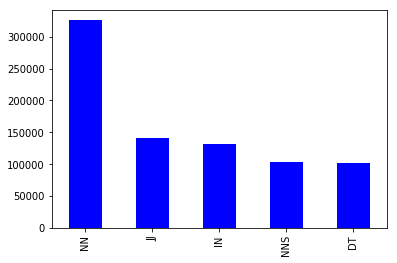

In [46]:
tags_df[1].value_counts()[:5].plot(kind='bar', color='blue')

Let's see if this corpus supports Zipf's law 

In [47]:
#Get word counts and ranks, sort by ranks, and get top 100 

count = tags_df[0].value_counts().sort_index().to_frame()
ranks = tags_df[0].value_counts().rank(ascending=False).to_frame()
zipfs = count.merge(ranks, left_index=True, right_index=True).sort_values(["0_y"],ascending=True)[:100]
zipfs.columns = ['Count', 'Rank']

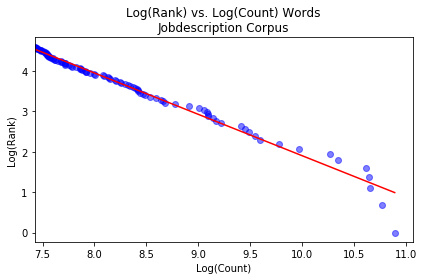

In [48]:
x = np.log(zipfs['Count'])
y = np.log(zipfs['Rank'])
fit = np.polyfit(x, y, deg = 1)
fitted = fit[0] * x + fit[1]

fig = plt.Figure(figsize = (4,4), facecolor='w', edgecolor='w')
ax = plt.subplot(111)
ax.plot(x, y, 'bo', alpha = 0.5)
ax.plot(x, fitted, 'r')

ax.set_title('Log(Rank) vs. Log(Count) Words\nJobdescription Corpus')
ax.set_xlabel('Log(Count)')
ax.set_ylabel('Log(Rank)')

ax.set_xlim(min(x))

plt.tight_layout()
plt.show()

Although rank and token frequency show an inverse relationship, when compared with theoretical prediction of the law, actual value diverges from predicted value. So Zipf's law does hold true in this case probably due to stopwords.

What would happen to word count and frequency if we remove stopwords and lemmatize? 

In [49]:
stop_words = set(stopwords.words('english'))
wtstop = []

for w in token: 
    if w not in stop_words: 
        wtstop.append(w)
lem = WordNetLemmatizer()
wtstop_lemmatized = DataFrame(map(lambda x: lem.lemmatize(x), wtstop))

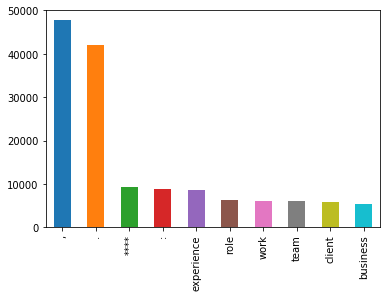

In [50]:
wtstop_lemmatized[0].value_counts(ascending=False)[:10].plot(kind='bar')

In [11]:
wtstop_lemmatized[0].value_counts(ascending=False)[:10]

,              5982
.              3033
responsible    1231
project        1168
looking        1144
development    1033
position       1015
)              1015
(               995
incumbent       976
Name: 0, dtype: int64

### Predict Salary from Job Description

Creating classification model with bag-of-words and explore the accuracy using confusion matrix 

In [90]:
salary_rank = df_sample['SalaryNormalized'].rank(ascending=False)
salary_percentile = pd.qcut(salary_rank, 4, 
                            labels = ['0-25', '25-50', '50-75', '75-100'])
df_sample['Salary Percentile'] = salary_percentile
df_sample['Target'] = 0.0 
mask = (df_sample['Salary Percentile'] == '0-25')
df_sample['Target'][mask] = 1.0 

In [91]:
df_sample['FullDescription'] = df_sample['FullDescription'].apply(lambda x: x.lower())
df_sample[['FullDescription', 'SalaryNormalized', 'Salary Percentile', 'Target']][:20]

,FullDescription,SalaryNormalized,Salary Percentile,Target
147010,instore promotions assistant immediate start ...,16800,75-100,0.0
113854,"automotive, motor trade job: motorcycle techni...",20000,75-100,0.0
210556,site or unit :the county care homeaddress :***...,21024,75-100,0.0
33286,an excellent opportunity to be part of a fast ...,50000,0-25,1.0
72045,our client is a major provider of precision ma...,34000,25-50,0.0
239507,"maintenance engineer, maintenance technician, ...",35000,25-50,0.0
55862,a large school in selby are looking for a full...,27840,50-75,0.0
229239,"with impressive growth of ****0% year on year,...",55000,0-25,1.0
3116,the client is seeking a highly motivated and s...,58000,0-25,1.0
173821,"my client, a large international organisation,...",21500,50-75,0.0


In [114]:
#Create Train and Test set 
df_train = df_sample[:8000]
df_test = df_sample[8000:]

#Create a document term matrix using CountVectorizer on the train set of the job description corpus 
count_vec = CountVectorizer()
count_dtm = count_vec.fit_transform(df_train['FullDescription'].tolist())

#Create Naive Bayes Classifier 
nb = MultinomialNB()
clf = nb.fit(count_dtm, df_train['Target'])

In [93]:
#Training Classification Matrix 
predicted = clf.predict(count_dtm)
metrics.confusion_matrix(df_train["Target"], predicted)

array([[5076,  899],
       [ 367, 1658]])

In [94]:
"Train Accuracy: ",metrics.accuracy_score(train["Target"], predicted)

('Train Accuracy: ', 0.84175)

In [96]:
#Test Classification Matrix 
count_dtm_test = count_vec.fit_transform(test['FullDescription'].tolist())
clf_2 = nb.fit(count_dtm_test, test['Target'])
predicted_test = clf_2.predict(count_dtm_test)
metrics.confusion_matrix(test['Target'], predicted_test)

array([[1346,  142],
       [  66,  446]])

In [97]:
"Test Accuracy: ", metrics.accuracy_score(test['Target'], predicted_test)

('Test Accuracy: ', 0.89600000000000002)

Would lemmatization help with the accuracy of classification?

- Lemmatization made almost no difference and rather lowered the accuracy by about 1%. This could have been from overfitting and possibly could be improved if we removed stopwords. 

In [98]:
#To lemmatize words like "performing", we need part of speech tags and this function creates the mapping of 
#the lemmatizer tags to the tokenizer tags 
def get_wordnet_pos(tag): 
    if tag.startswith('J'): 
        return wordnet.ADJ
    elif tag.startswith('V'): 
        return wordnet.VERB
    elif tag.startswith('N'): 
        return wordnet.NOUN
    elif tag.startswith('R'): 
        return wordnet.ADV
    else: 
        return ''

#To lemmatize a word if we have a part of speech tag or not 
def lemma(x): 
    lemmatizer = WordNetLemmatizer()
    if get_wordnet_pos(x[1]) != '': 
        return lemmatizer.lemmatize(x[0], get_wordnet_pos(x[1]))
    return lemmatizer.lemmatize(x[0])

#Tokenize, tag, and lemmatize Job Description corpus 
df_token = df_sample.copy()
df_token['FullDescription'] = df_token['FullDescription'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
df_token['FullDescription'] = df_token['FullDescription'].apply(lambda x: map(lemma, x))

In [99]:
#Split into train and test set 
train_lem = df_token[:8000]
test_lem = df_token[8000:]

#Create a document term matrix using CountVectorizer on the train set of the job description corpus 
ct_vec = CountVectorizer()
ct_dtm = ct_vec.fit_transform(train_lem['FullDescription'].apply(lambda x: ' '.join(x)))
nb = MultinomialNB()
clf = nb.fit(ct_dtm, train_lem['Target'])

#Accuracy and confusion matrix on lemmatized train data 
predict = clf.predict(ct_dtm)
print metrics.confusion_matrix(train_lem['Target'], predict)

#Accuracy and confusion matrix on lemmatized test data 
ct_dtm_test = ct_vec.fit_transform(test_lem['FullDescription'].apply(lambda x: ' '.join(x)))
clf_2 = nb.fit(ct_dtm_test, test_lem['Target'])
predict_test = clf_2.predict(ct_dtm_test)
metrics.confusion_matrix(test_lem['Target'], predict_test)

array([[1334,  154],
       [  67,  445]])

In [100]:
"Test Accuracy: ", metrics.accuracy_score(test_lem['Target'], predict_test)

('Test Accuracy: ', 0.88949999999999996)

In [101]:
"Train Accuracy: ", metrics.accuracy_score(train_lem['Target'], predict)

('Train Accuracy: ', 0.83962499999999995)

Using Pipeline to reduce the number of lines of code and test different parameters and classifiers 

In [160]:
#removing the stop_words weren't helpful in increasing the accuracy 
text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words = 'english')), 
                         ('tfidf', TfidfTransformer()), 
                        ('clf-svm', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, n_iter=5))
                        ])
text_clf_svm = text_clf_svm.fit(df_train['FullDescription'], df_train['Target'])
predicted_svm = text_clf_svm.predict(df_test['FullDescription'])
"Test Accuracy for SVM: ", metrics.accuracy_score(df_test['Target'], predicted_svm)

('Test Accuracy for SVM: ', 0.83450000000000002)

In [147]:
param = {'vect__ngram_range': [(1,1), (1,2)],
         'tfidf__use_idf': ('True', 'False'),
         'clf-svm__alpha': (1e-2, 1e-3),
        }
gs_clf = GridSearchCV(text_clf_svm, param, n_jobs=-1)
gs_clf = gs_clf.fit(df_train['FullDescription'], df_train['Target'])


In [148]:
gs_clf.best_params_

{'clf-svm__alpha': 0.001,
 'tfidf__use_idf': 'True',
 'vect__ngram_range': (1, 1)}

In [149]:
#Grid Search didn't improve the test accuracy. 
predict_gs = gs_clf.predict(df_test['FullDescription'])
"Test Accuracy after GridSearch:", metrics.accuracy_score(df_test['Target'], predict_gs)

('Test Accuracy after GridSearch:', 0.77000000000000002)

Overall, Naive Bayes Classifier did the best in classifying the Target salary from job description in terms of accuracy score. To expand further, we can run gridsearch on more wide array of parameters to find optimal parameters, but this comes at a cost of computing time. 